# Metabolism of Cities - Adding Data about Dam Levels in Cape Town

## About the Metabolism of Cities Project

Metabolism of Cities’ mission is to collaborate on improving the sustainability of cities in a holistic way. They do this through:

- creating knowledge;
- sharing knowledge;
- applying knowledge; and
- fostering a community.

The project is a collaboration between citizens, city officials, academia, and businesses. It was created by Paul Hoekman in 2014 and has since grown into a multinational open source, open science collaboration. More information is available at [https://metabolismofcities.org/](https://metabolismofcities.org/).

## Contributing Data

The Metabolism of Cities project collate information about material flow through cities. A wide variety of data is needed to understand the full picture of material flow through a city and therefore this project lends itself very well for people from all ages, skill level, background, to contribute.

For more about how to get involved or contribute to this project, please visit [their website](https://metabolismofcities.org/about/join).

## Hackday for Human Rights

On 1 June 2019 [Codebridge Newlands](https://codebridge.org.za/) (an open community at the intersection of civic-tech and social change) hosted a [Hackday for Human Rights](https://www.meetup.com/Codebridge/events/261221137/) in Cape Town. Several projects were pitched on the day and participants could select which of the projects they'd like to contribute to. Amongst these were the Metabolism of Cities Project.

Paul Hoekman introduced the project at the start of the day and provided very clear guidelines and resources to make it easy to contribute. We used a Trello Board to see who is contributing to which aspects of the project. Paul also made available some instructional videos about contributing. Links to these resources are available [here](https://metabolismofcities.org/community/news/178).

## Dam Levels of Cape Town

I decided to tackle the dam levels data set as it would give me an opportunity to familiarise myself with the [City of Cape Town's Open Data Portal](https://web1.capetown.gov.za/web1/OpenDataPortal/Default) which I've heard a lot about since its inception, but have never used.

Paul provided the link to the [dataset for dam levels between 2011 and 2019](https://web1.capetown.gov.za/web1/OpenDataPortal/DatasetDetail?DatasetName=Dam%20levels). 

## Data Wrangling

As with most projects, there is a lot of data cleaning, reformatting, and checking to be done, before data can actually be used. It wasn't any different for this dataset. The data is available in a comma seperated file but comes with no metadata or README file to describe the format or contents. Luckily it isn't a very complicated dataset. Here is a screenshot of the raw data opened in LibreOffice (a free and opensource alternative for Microsoft Excel):



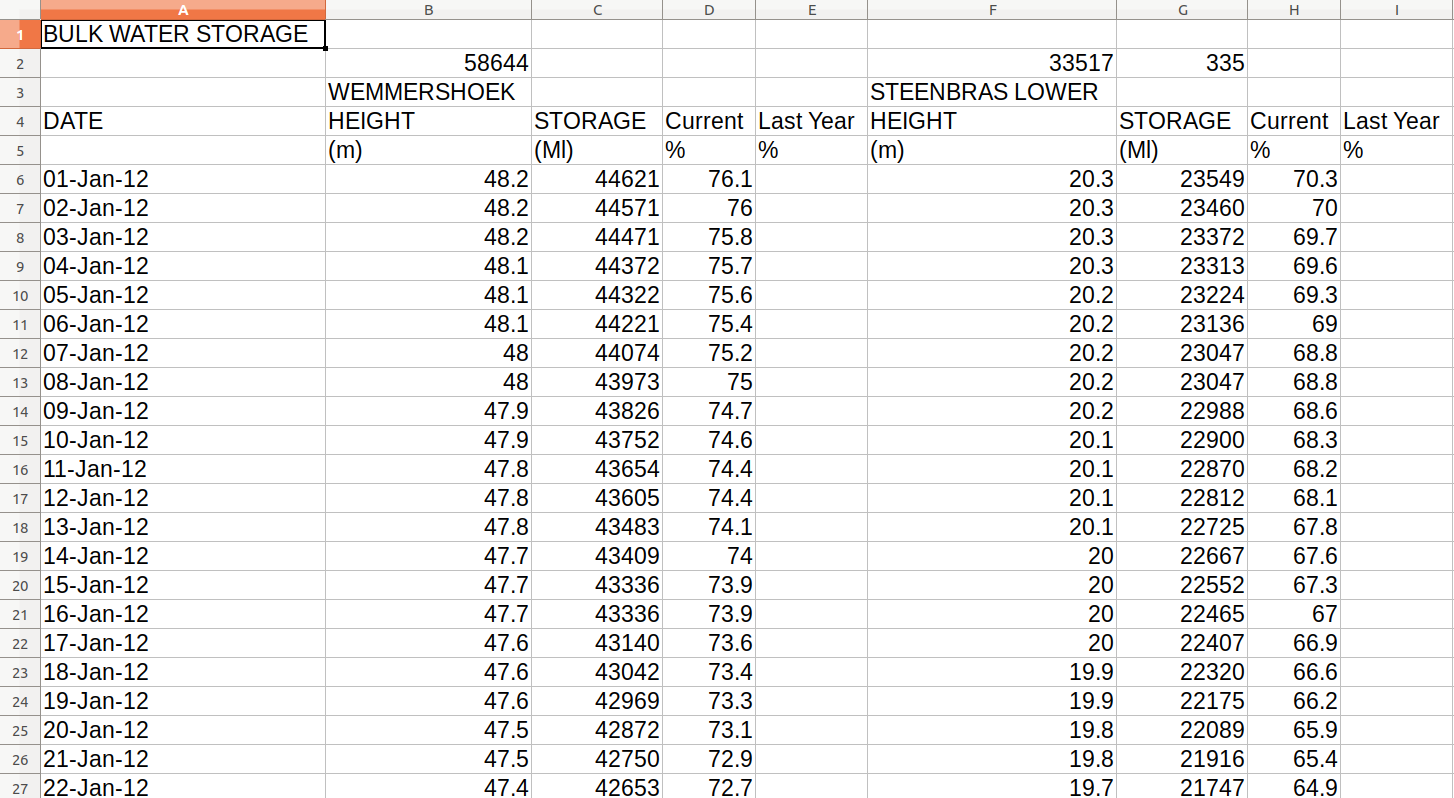

In [1]:
from IPython.display import Image 
Image(filename='images/dam_levels_screenshot.png')

## Data Description

- Row 1: Header
- Row 2: Inconsistent, but from [another website](https://www.capetown.gov.za/Family%20and%20home/residential-utility-services/residential-water-and-sanitation-services/this-weeks-dam-levels) it appears as the capacity of each dam when full given in Ml which may be million litres, but there was no explanation on the site for this abbreviation. In some cases the capacity in Ml is also divided by 100 in a subsequent column
- Row 3: Dam name
- Row 4: Headers for columns with data. Dam levels were measured on a daily basis (column 1). Subsequent columns provide information for each of the 13 dams followed by some summarisation for the big 6 dams. Each dam has information about:

  - Height in metres
  - Storag in Ml (million litres?)
  - Current percentage
  - A fourth column is provided for the measurement on the same day for the previous year, but no data is available in this column
  
- Row 5: Units of measurement for each column
- Row 6 - 2712: Measurements for each day for each dam between 1 January 2012 - 30 May 2019



## Purpose of this Notebook

I created this Notebook to share the code that is used to convert the native City of Cape Town Open Data Portal data format for dam levels to the required format for submission to the Metabolism of Cities database as described on their website. The following columns are required:

### _\*\*\*Useful tip:_
_Metabolism of Cities made useful videos available that provides insight into the upload process, data format, and more. You can find these under their [Resources page](https://metabolismofcities.org/resources)._

- Timeframe name
- From (date)
- To (date)
- Material name
- Material code (find codification [here](https://metabolismofcities.org/cities/materials/))
- Quantity
- Unit
- Location
- Comments

There is also a requirement to submit metadata including where the data was obtained from and more.

## A. Let's Get Cracking with Fixing the Data!

To make data understandable to computers, we have to provide it in a format where every row is an observation and every column contains information that describes each observation (i.e. every column is a variable). 

###  \*\*\*_Useful tip:_
_For more information on tabular data formatting for analysis, please see one of my favourite tutorials from [The Carpentries](https://carpentries.org) on [Data organisation in spreadsheets](https://datacarpentry.org/spreadsheet-ecology-lesson/)._



Since our dataset is not machine readable yet, we'll take a look at the data and decide how to organise it best. After we've converted the data to be machine readable, we can manipulate it to be in the format that is required by Metabolism of Cities.

### 1. Reading in the data

In [333]:
# Import packages required for reading files
import pandas as pd
import datetime
import numpy as np

In [343]:
# Read in the raw data but skip the first meaningless row
dams_spreadsheet = pd.read_csv("Dam levels 2012 to 2019.csv", skiprows = 1, header = None, encoding = "ISO-8859-1")

In [344]:
dams_spreadsheet.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,NaN,58644,NaN,NaN,NaN,33517,335,NaN,NaN,31767,...,NaN,NaN,898221,NaN,NaN,NaN,451,NaN,NaN,NaN
1,NaN,WEMMERSHOEK,NaN,NaN,NaN,STEENBRAS LOWER,NaN,NaN,NaN,STEENBRAS UPPER,...,NaN,NaN,TOTAL STORED - BIG 6,NaN,NaN,NaN,LAND-en ZEEZICHT,NaN,NaN,NaN
2,DATE,HEIGHT,STORAGE,Current,Last Year,HEIGHT,STORAGE,Current,Last Year,HEIGHT,...,Current,Last Year,STORAGE,Current,Last Year,NaN,HEIGHT,STORAGE,Current,Last Year
3,NaN,(m),(Ml),%,%,(m),(Ml),%,%,(m),...,%,%,(Ml),%,%,NaN,(m),(Ml),%,%
4,01-Jan-12,48.2,44621,76.1,NaN,20.3,23549,70.3,NaN,24.2,...,89.2,NaN,695783,77.5,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Obtain the dam capacity when full from row 1 in the dataframe (which corresponds to row 2 in the CSV file)

We will exclude the last two numbers in this row because they correspond to a cumulative capacity for the top 6 dams and a dam without any information respectively.

We'll use this data later when we calculate the dam level percentage from the measured capacity.

In [345]:
# Get the dam capacity when full from row 1 and convert it from text to numeric format
# Every dam has 4 columns associated with it, we are excluding the last 8 columns as described above

dam_capacity = []

for index in range(1, len(dams_spreadsheet.iloc[0]) - 8, 4):
    dam_capacity.append(pd.to_numeric(dams_spreadsheet.iloc[0,index]))

print(dam_capacity)

[58644, 33517, 31767, 164095, 925, 955, 128, 134, 242, 1301, 168, 480188, 130010]


### 3. Obtain the dam names from row 2 in the dataframe (corresponds to row 3 in the CSV file)

We will exclude the last two elements again as described above.

In [346]:
# Get the dam names from row 2
dam_names = []

for index in range(len(dams_spreadsheet.iloc[1]) - 8):
    if not pd.isnull(dams_spreadsheet.iloc[1,index]):
        dam_names.append(dams_spreadsheet.iloc[1,index])

print(dam_names)

['WEMMERSHOEK', 'STEENBRAS LOWER', 'STEENBRAS UPPER', 'VOËLVLEI', 'HELY-HUTCHINSON', 'WOODHEAD', 'VICTORIA', 'ALEXANDRA', 'DE VILLIERS', 'KLEINPLAATS', 'LEWIS GAY', 'THEEWATERSKLOOF', 'BERG RIVER']


### 4. Fix the dates so that Python recognise it as a datetime object for timeseries analysis

In [347]:
# Convert dates to date.time format 
# PLEASE NOTE THAT THE DATES FOR 2017 WERE ENTERED AS DD/MM/YYYY AND FOR THE OTHER YEARS IT WAS ENTERED AS DD-MMM-YYYY
# Run only ONCE as it changes the original dataframe

for dates in range(4, len(dams_spreadsheet)):
    if '-' in dams_spreadsheet.iloc[dates,0]:
        dams_spreadsheet.iloc[dates, 0] = datetime.datetime.strptime(dams_spreadsheet.iloc[dates, 0], '%d-%b-%y')
    else:
        dams_spreadsheet.iloc[dates, 0] = datetime.datetime.strptime(dams_spreadsheet.iloc[dates, 0], '%d/%m/%Y')

### 5. Create column names for the new dataframe which we'll create from the old dataframe

In [349]:
# Create column names for cleaned up data
# Column 1 = date
# Followed by 3 columns per dam (13 dams - excluding the summarised data for the big 6 and "Land en Zeezicht" which has no data associated)
# Columns per dam: height, capacity, percentage

column_names = []
for index in range(0, len(dam_names)):
    column_names.append(str('height_') + dam_names[index])
    column_names.append(str('capacity_') + dam_names[index])
    column_names.append(str('percentage_') + dam_names[index])
    column_names.append(str('discard_') + dam_names[index])
    
print(column_names)

['height_WEMMERSHOEK', 'capacity_WEMMERSHOEK', 'percentage_WEMMERSHOEK', 'discard_WEMMERSHOEK', 'height_STEENBRAS LOWER', 'capacity_STEENBRAS LOWER', 'percentage_STEENBRAS LOWER', 'discard_STEENBRAS LOWER', 'height_STEENBRAS UPPER', 'capacity_STEENBRAS UPPER', 'percentage_STEENBRAS UPPER', 'discard_STEENBRAS UPPER', 'height_VOËLVLEI', 'capacity_VOËLVLEI', 'percentage_VOËLVLEI', 'discard_VOËLVLEI', 'height_HELY-HUTCHINSON', 'capacity_HELY-HUTCHINSON', 'percentage_HELY-HUTCHINSON', 'discard_HELY-HUTCHINSON', 'height_WOODHEAD', 'capacity_WOODHEAD', 'percentage_WOODHEAD', 'discard_WOODHEAD', 'height_VICTORIA', 'capacity_VICTORIA', 'percentage_VICTORIA', 'discard_VICTORIA', 'height_ALEXANDRA', 'capacity_ALEXANDRA', 'percentage_ALEXANDRA', 'discard_ALEXANDRA', 'height_DE VILLIERS', 'capacity_DE VILLIERS', 'percentage_DE VILLIERS', 'discard_DE VILLIERS', 'height_KLEINPLAATS', 'capacity_KLEINPLAATS', 'percentage_KLEINPLAATS', 'discard_KLEINPLAATS', 'height_LEWIS GAY', 'capacity_LEWIS GAY', 'pe

### 6. Create a new dataframe with 3 columns for each dam from the old dataframe 

It turns out that there are a few typing errors in the dataset that have to be fixed to automate some of the other analysis. The changes to the raw dataset is described in detail below.

In [350]:
dams_dict = {}

# The last 32 rows of the dataset has dates but no data associated. We'll drop those rows from the new dataframe

dams_dict['date'] = dams_spreadsheet.iloc[4:-32,0]

#### a) White space as thousands separator

The numbers were read in as text and it turns out some of the numbers have white-space as thousands seperators
We have to remove all white space from the numbers before converting from text to float
We'll convert the strings to numbers after we fixed the #VALUE! problem identified below...

In [351]:
for col_idx, col_name in enumerate(column_names):
    dams_dict[col_name] = dams_spreadsheet.iloc[4:-32, col_idx + 1].str.replace(" ", "")

# Create the new final dataframe and set index to be the dates for timeseries analysis
dams_df = pd.DataFrame.from_dict(dams_dict)


In [352]:
dams_df.columns

Index(['date', 'height_WEMMERSHOEK', 'capacity_WEMMERSHOEK',
       'percentage_WEMMERSHOEK', 'discard_WEMMERSHOEK',
       'height_STEENBRAS LOWER', 'capacity_STEENBRAS LOWER',
       'percentage_STEENBRAS LOWER', 'discard_STEENBRAS LOWER',
       'height_STEENBRAS UPPER', 'capacity_STEENBRAS UPPER',
       'percentage_STEENBRAS UPPER', 'discard_STEENBRAS UPPER',
       'height_VOËLVLEI', 'capacity_VOËLVLEI', 'percentage_VOËLVLEI',
       'discard_VOËLVLEI', 'height_HELY-HUTCHINSON',
       'capacity_HELY-HUTCHINSON', 'percentage_HELY-HUTCHINSON',
       'discard_HELY-HUTCHINSON', 'height_WOODHEAD', 'capacity_WOODHEAD',
       'percentage_WOODHEAD', 'discard_WOODHEAD', 'height_VICTORIA',
       'capacity_VICTORIA', 'percentage_VICTORIA', 'discard_VICTORIA',
       'height_ALEXANDRA', 'capacity_ALEXANDRA', 'percentage_ALEXANDRA',
       'discard_ALEXANDRA', 'height_DE VILLIERS', 'capacity_DE VILLIERS',
       'percentage_DE VILLIERS', 'discard_DE VILLIERS', 'height_KLEINPLAATS',
      

#### b) Dates were entered incorrectly

The following dates were entered incorrectly (probably a function of the 'drag-to-copy' function in Excel:
- 19 May 2018 should be 19 May 2017 (row 1971 in CSV; row 1965 in dataframe)
- 20 May 2019 should be 20 May 2017 (row 1972 in CSV; row 1966 in dataframe)
- 21 May 2020 should be 21 May 2017 (row 1973 in CSV; row 1967 in dataframe)
- 22 May 2021 should be 22 May 2017 (row 1974 in CSV; row 1968 in dataframe)

In [353]:
for date_fix_index in range(1965, 1969):
    dams_df.iloc[date_fix_index]['date'] = dams_df.iloc[date_fix_index]['date'].replace(year = 2017)

#### c) Some rows contain the value '#VALUE!'

Row number 1998 in the original CSV file (row 1992 in this dataset) have a number of columns with the value "#VALUE!". 

We will replace these values with the recognised 'NaN' that reflects missing values in Python.

In [354]:
dams_df = dams_df.replace('#VALUE!', np.nan)

### 7. Now we are ready to use the dates as index for downstream time series analysis

In [355]:
dams_df.set_index('date', inplace=True)

In [356]:
# Convert data to numeric values
for columns in dams_df.columns:
    dams_df[columns] = pd.to_numeric(dams_df[columns])


# Discard the columns with previous year percentage which is empty in the original dataset
to_discard = [col for col in dams_df.columns if 'discard' in col]
dams_df.drop(to_discard, axis = 1, inplace = True)

# We now have the data that is needed in a format that we can work with (data for every day)
dams_df.head()
dams_df.columns

Index(['height_WEMMERSHOEK', 'capacity_WEMMERSHOEK', 'percentage_WEMMERSHOEK',
       'height_STEENBRAS LOWER', 'capacity_STEENBRAS LOWER',
       'percentage_STEENBRAS LOWER', 'height_STEENBRAS UPPER',
       'capacity_STEENBRAS UPPER', 'percentage_STEENBRAS UPPER',
       'height_VOËLVLEI', 'capacity_VOËLVLEI', 'percentage_VOËLVLEI',
       'height_HELY-HUTCHINSON', 'capacity_HELY-HUTCHINSON',
       'percentage_HELY-HUTCHINSON', 'height_WOODHEAD', 'capacity_WOODHEAD',
       'percentage_WOODHEAD', 'height_VICTORIA', 'capacity_VICTORIA',
       'percentage_VICTORIA', 'height_ALEXANDRA', 'capacity_ALEXANDRA',
       'percentage_ALEXANDRA', 'height_DE VILLIERS', 'capacity_DE VILLIERS',
       'percentage_DE VILLIERS', 'height_KLEINPLAATS', 'capacity_KLEINPLAATS',
       'percentage_KLEINPLAATS', 'height_LEWIS GAY', 'capacity_LEWIS GAY',
       'percentage_LEWIS GAY', 'height_THEEWATERSKLOOF',
       'capacity_THEEWATERSKLOOF', 'percentage_THEEWATERSKLOOF',
       'height_BERG RIVER', '

### 8. And finally we can downsample the data to provide monthly or quarterly data, whichever is preferred.

For the Metabolism of Cities, we'll provide data aggregated per month

In [357]:
dam_levels_monthly = dams_df.resample('M').mean().round(2)

In [358]:
dam_levels_monthly

,height_WEMMERSHOEK,capacity_WEMMERSHOEK,percentage_WEMMERSHOEK,height_STEENBRAS LOWER,capacity_STEENBRAS LOWER,percentage_STEENBRAS LOWER,height_STEENBRAS UPPER,capacity_STEENBRAS UPPER,percentage_STEENBRAS UPPER,height_VOËLVLEI,...,percentage_KLEINPLAATS,height_LEWIS GAY,capacity_LEWIS GAY,percentage_LEWIS GAY,height_THEEWATERSKLOOF,capacity_THEEWATERSKLOOF,percentage_THEEWATERSKLOOF,height_BERG RIVER,capacity_BERG RIVER,percentage_BERG RIVER
date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,47.66,43222.74,73.71,19.94,22370.90,66.75,24.19,29651.52,93.34,14.44,...,24.46,13.46,116.81,69.49,24.31,336195.97,70.02,38.03,109432.90,84.17
2012-02-29,46.18,39691.41,67.68,18.97,19661.62,58.68,23.92,28981.21,91.23,13.22,...,21.69,12.05,84.38,50.20,23.30,295272.21,61.49,35.38,96106.93,73.92
2012-03-31,43.56,33966.74,57.93,17.77,16657.32,49.70,21.68,23682.87,74.55,12.11,...,19.77,11.10,65.94,39.23,22.40,262393.19,54.64,32.78,84010.03,64.59
2012-04-30,41.13,29017.83,49.47,16.91,14665.47,43.75,17.49,15534.73,48.91,11.22,...,18.22,9.74,45.97,27.24,22.02,248849.33,51.82,31.32,77451.33,59.57
2012-05-31,40.35,27569.81,47.01,17.01,14907.61,44.48,16.95,14544.39,45.79,10.87,...,19.05,10.44,56.52,33.60,22.01,248747.06,51.80,31.89,80021.94,61.56
2012-06-30,40.48,27808.07,47.41,17.88,16945.07,50.57,20.18,20565.50,64.75,11.22,...,34.67,14.13,136.50,81.21,22.60,269573.30,56.14,33.88,89068.33,68.52
2012-07-31,43.91,34711.23,59.19,20.60,24545.35,73.23,24.58,30716.71,96.69,13.11,...,61.12,15.30,169.45,100.67,23.96,321289.74,66.90,39.14,115000.00,88.46
2012-08-31,49.28,47633.58,81.23,23.21,32887.61,98.11,24.97,31697.84,99.78,15.07,...,91.25,15.29,169.16,100.51,25.77,400581.52,83.43,42.15,130700.97,100.54
2012-09-30,53.36,58679.50,100.07,23.26,33059.90,98.63,24.63,30786.67,96.92,17.47,...,99.64,15.30,169.77,100.80,27.39,477079.97,99.37,42.16,130800.33,100.61


## B. Creating the Metabolism of Municipalities data format

### 1. Data format (a reminder)

Here is what we need in the end:

#### a) Timeframe name

We will use the month name and year as the timeframe name e.g. "January 2019"

#### b) From (date)

We will use the start day of the month obtained from the index (date) as the 'from' date

#### c) To (date)

We will use the index date as the to (date)

#### d) Material name

Water

#### e) Material code 

MF9

#### f) Quantity

We have 3 options - to use either the height, capacity, or percentage that is available for each dam in our dataframe. I will use the __percentage__, but the rest of the data is available if Metabolism of Cities would like to have the other datapoints in future.

#### g) Unit

%

#### h) Location

Name of Dam.

It is important to note that the name used here, should already be in the Metabolism of Cities dataset if we want to use it here. I checked, and thankfully the dams are already available in the database along with other information about them such as year built, capacity, and more! 

I will probably have to change the capitalisation to resemble the data in Metabolism of Cities, but that can easily be done in Python.

#### i) Comments

For now I won't add any comments as most of my comments are available in this notebook, and there is a dedicated section to upload Metadata where I can point to this notebook.

### 2. How to go about this...???

There are many ways to do this, but I've decided to create a dataframe per dam as we need each measurement for each date for each dam over the timeframe of the dataset.

In [406]:
# reset index to use downstream

dam_levels_monthly = dam_levels_monthly.reset_index()
    
# Create content for static columns

time_frame = dam_levels_monthly['date'].dt.strftime("%B %Y")
start_time = dam_levels_monthly['date'].dt.strftime("01/%m/%y")
end_time = dam_levels_monthly['date'].dt.strftime("%d/%m/%y")
material_name = ['water'] * len(dam_levels_monthly)
material_code = ['MF9'] * len(dam_levels_monthly)
unit = ['%'] * len(dam_levels_monthly)

# Create dictionary for each dam 
# In final step convert dictionary to dataframe and export dataframe to CSV called 'dam_name.csv'

dam_dicts= {}

# Create content for columns relevant to each dam
for dam in dam_names:
    dam_dicts[dam] = {'Timeframe Name': time_frame.values.tolist(),
                'From (date)': start_time.values.tolist(),
                'To (date)':   end_time.values.tolist(),
                'Material name': material_name,
                'Material code': material_code,
                'Quantity':   dam_levels_monthly[str('percentage_' + dam)].values.tolist(),
                'Unit' :      unit,
                'Location':   [dam] * len(dam_levels_monthly),
                'Comments':    [""] * len(dam_levels_monthly)
               }

    export_file_path = str('metabolism_files/') + dam + str('.csv')
    pd.DataFrame.from_dict(dam_dicts[dam]).to_csv(export_file_path, header = True, index = None)
    